In [72]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scapy.all import rdpcap, IP, TCP, UDP

In [ ]:
packets = rdpcap('pcaps/online_gaming2.pcap')
local_subnet = '192.168.1.0/24'
local_ip = '192.168.1.205'  
timestamps = []
packet_sizes = []
protocols = []
src_ports = []
dst_ports = []
directions = []  

In [74]:

for pkt in packets:
    if IP in pkt:
        src_ip = pkt[IP].src
        dst_ip = pkt[IP].dst
        timestamps.append(float(pkt.time))  
        packet_sizes.append(len(pkt))
        
        if src_ip == local_ip:
            directions.append('Uplink')  # Outgoing packet from local IP
        elif dst_ip == local_ip:
            directions.append('Downlink')  # Incoming packet to local IP
        else:
            directions.append('Other')  # Neither uplink nor downlink
        
        if pkt.haslayer(TCP):
            protocols.append('TCP')
            src_ports.append(pkt[TCP].sport)
            dst_ports.append(pkt[TCP].dport)
        elif pkt.haslayer(UDP):
            protocols.append('UDP')
            src_ports.append(pkt[UDP].sport)
            dst_ports.append(pkt[UDP].dport)
        else:
            protocols.append('Other')
            src_ports.append(None)
            dst_ports.append(None)

df = pd.DataFrame({
    'Timestamp': pd.to_datetime(timestamps, unit='s', errors='coerce'),
    'PacketSize': packet_sizes,
    'Protocol': protocols,
    'SourcePort': src_ports,
    'DestinationPort': dst_ports,
    'Direction': directions
})

df.dropna(subset=['Timestamp'], inplace=True)
df.set_index('Timestamp', inplace=True)

uplink_df = df[df['Direction'] == 'Uplink']
downlink_df = df[df['Direction'] == 'Downlink']


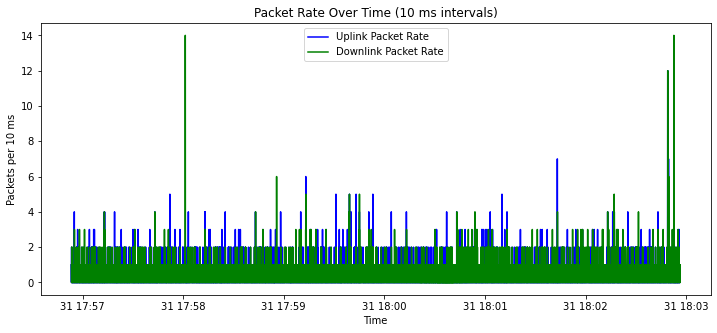

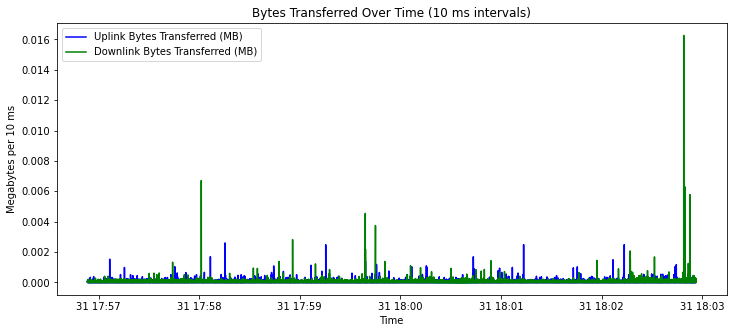

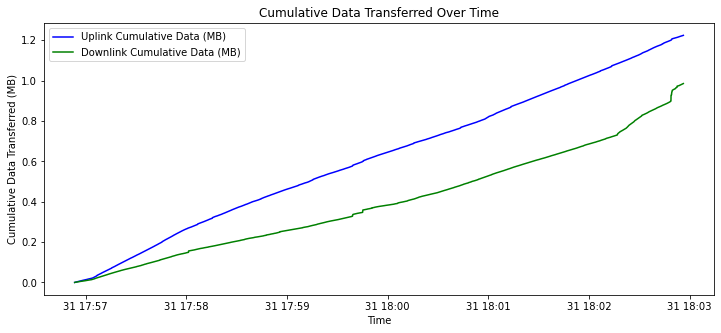

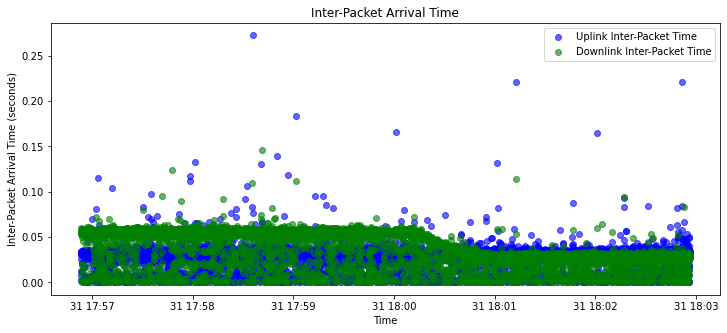

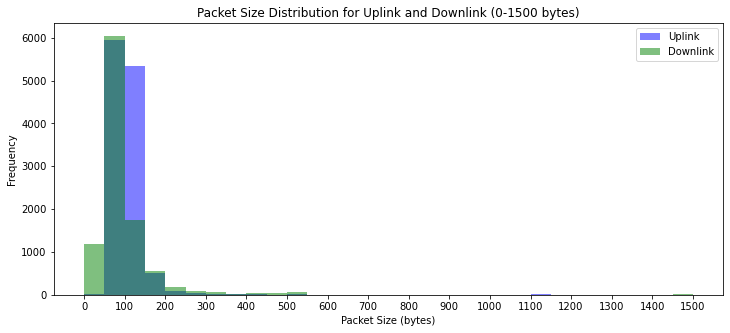

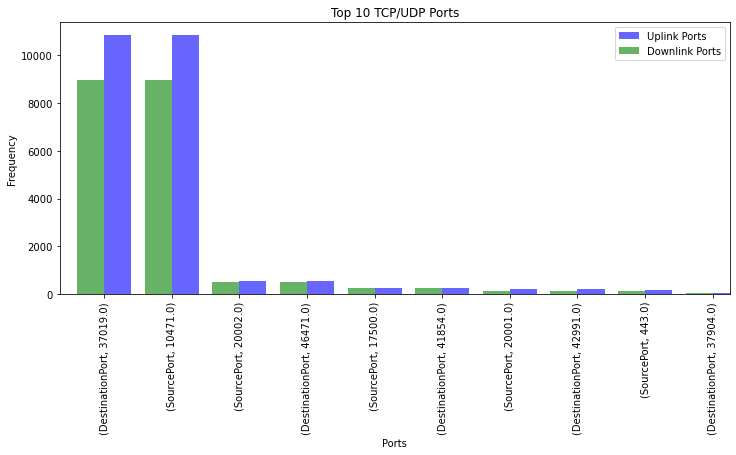

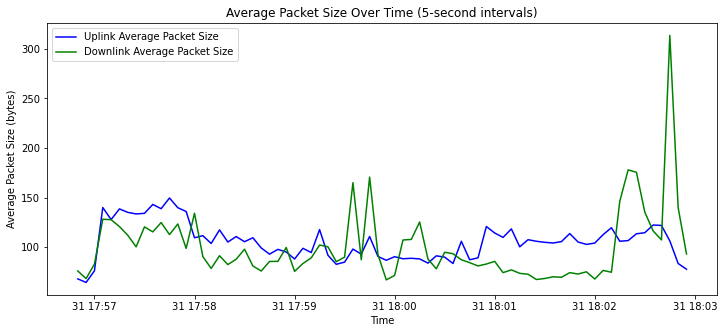

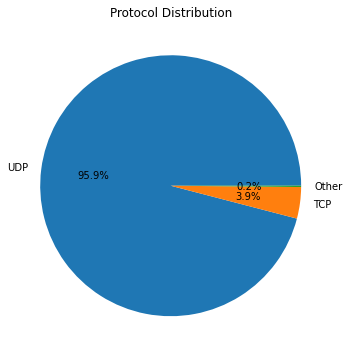

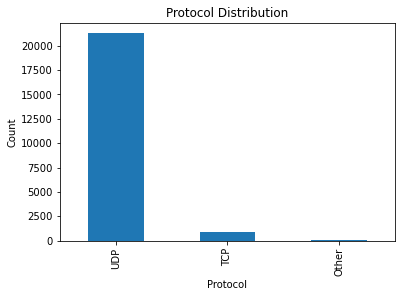

In [75]:

uplink_packet_rate = uplink_df.resample('10L').size()
downlink_packet_rate = downlink_df.resample('10L').size()

plt.figure(figsize=(12, 5))
plt.plot(uplink_packet_rate, label='Uplink Packet Rate', color='blue')
plt.plot(downlink_packet_rate, label='Downlink Packet Rate', color='green')
plt.xlabel('Time')
plt.ylabel('Packets per 10 ms')
plt.title('Packet Rate Over Time (10 ms intervals)')
plt.legend()
plt.show()

uplink_bytes_transferred = uplink_df['PacketSize'].resample('10L').sum()
downlink_bytes_transferred = downlink_df['PacketSize'].resample('10L').sum()

plt.figure(figsize=(12, 5))
uplink_bytes_transferred_mb = uplink_bytes_transferred / 1_048_576
downlink_bytes_transferred_mb = downlink_bytes_transferred / 1_048_576
plt.plot(uplink_bytes_transferred_mb, label='Uplink Bytes Transferred (MB)', color='blue')
plt.plot(downlink_bytes_transferred_mb, label='Downlink Bytes Transferred (MB)', color='green')
plt.xlabel('Time')
plt.ylabel('Megabytes per 10 ms')
plt.title('Bytes Transferred Over Time (10 ms intervals)')
plt.legend()
plt.show()

uplink_cumulative_data = uplink_df['PacketSize'].cumsum()
downlink_cumulative_data = downlink_df['PacketSize'].cumsum()

plt.figure(figsize=(12, 5))
uplink_cumulative_data_mb = uplink_cumulative_data / 1_048_576
downlink_cumulative_data_mb = downlink_cumulative_data / 1_048_576
plt.plot(uplink_cumulative_data_mb, label='Uplink Cumulative Data (MB)', color='blue')
plt.plot(downlink_cumulative_data_mb, label='Downlink Cumulative Data (MB)', color='green')
plt.xlabel('Time')
plt.ylabel('Cumulative Data Transferred (MB)')
plt.title('Cumulative Data Transferred Over Time')
plt.legend()
plt.show()


uplink_inter_arrival_time = uplink_df.index.to_series().diff().dt.total_seconds()
downlink_inter_arrival_time = downlink_df.index.to_series().diff().dt.total_seconds()

plt.figure(figsize=(12, 5))
plt.plot(uplink_inter_arrival_time, label='Uplink Inter-Packet Time', color='blue', marker='o', linestyle='None', alpha=0.6)
plt.plot(downlink_inter_arrival_time, label='Downlink Inter-Packet Time', color='green', marker='o', linestyle='None', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Inter-Packet Arrival Time (seconds)')
plt.title('Inter-Packet Arrival Time')
plt.legend()
plt.show()


plt.figure(figsize=(12, 5))
uplink_df['PacketSize'].plot(kind='hist', bins=30, alpha=0.5, color='blue', label='Uplink', range=(0, 1500))
downlink_df['PacketSize'].plot(kind='hist', bins=30, alpha=0.5, color='green', label='Downlink', range=(0, 1500))
plt.xticks(np.arange(0, 1600, 100))
plt.xlabel("Packet Size (bytes)")
plt.ylabel("Frequency")
plt.title("Packet Size Distribution for Uplink and Downlink (0-1500 bytes)")
plt.legend()
plt.show()


uplink_top_ports = uplink_df[['SourcePort', 'DestinationPort']].melt().value_counts().head(10)
downlink_top_ports = downlink_df[['SourcePort', 'DestinationPort']].melt().value_counts().head(10)

plt.figure(figsize=(12, 5))
uplink_top_ports.plot(kind='bar', color='blue', alpha=0.6, position=0, width=0.4, label='Uplink Ports')
downlink_top_ports.plot(kind='bar', color='green', alpha=0.6, position=1, width=0.4, label='Downlink Ports')
plt.xlabel('Ports')
plt.ylabel('Frequency')
plt.title('Top 10 TCP/UDP Ports')
plt.legend()
plt.show()

uplink_avg_size = uplink_df['PacketSize'].resample('5S').mean()
downlink_avg_size = downlink_df['PacketSize'].resample('5S').mean()

plt.figure(figsize=(12, 5))
plt.plot(uplink_avg_size, label='Uplink Average Packet Size', color='blue')
plt.plot(downlink_avg_size, label='Downlink Average Packet Size', color='green')
plt.xlabel('Time')
plt.ylabel('Average Packet Size (bytes)')
plt.title('Average Packet Size Over Time (5-second intervals)')
plt.legend()
plt.show()


protocol_counts = df['Protocol'].value_counts()
protocol_counts.plot(kind='pie', autopct='%1.1f%%', title="Protocol Distribution", figsize=(6, 6))
plt.ylabel("")  
plt.show()

protocol_counts.plot(kind='bar', title="Protocol Distribution")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.show()
